# Problems with U-235 xs covariance matrix from ENDF/B-VIII.0

In [1]:
import sandy
import numpy as np
from numpy.linalg import eig
import pandas as pd
from scipy.linalg import svd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Parametric analysis of the covariance matrix using different NJOY energy grids

- IGN=2 : SCALE 239 group structure
- IGN=3: LANL 30 group structure
- IGN=9 : WIMS 69 group structure

In [3]:
tape = sandy.get_endf6_file("endfb_80", "xs", 922350)

In [4]:
kws = dict(err=1, chi=False, nubar=False, mubar=False,)
covs = {
    2: tape.get_errorr(**kws, errorr33_kws=dict(ign=2))["errorr33"].get_cov(),
    3: tape.get_errorr(**kws, errorr33_kws=dict(ign=3))["errorr33"].get_cov(),
    9: tape.get_errorr(**kws, errorr33_kws=dict(ign=9))["errorr33"].get_cov(),
}

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    
INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    
INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


## Plot correlation matrices and uncertainties

In [5]:
mts = [1, 2, 4, 18, 102]

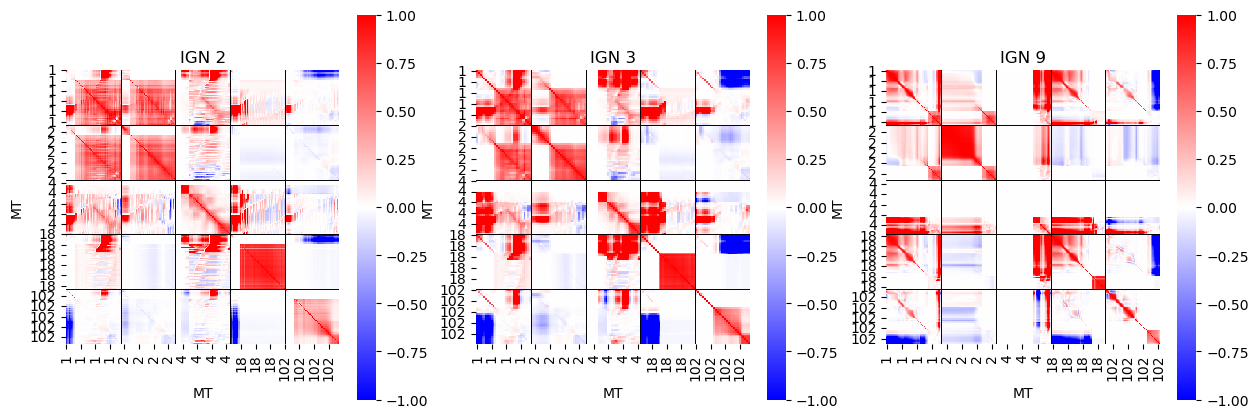

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

ax = axs[0]
ign = 2
idx = pd.IndexSlice
c = sandy.CategoryCov(covs[ign].data.loc[
    idx[:, mts, :],  # Filter rows with MT in list
    idx[:, mts, :]   # Filter columns with MT in list
]).get_corr().data
c.index = c.columns = c.index.get_level_values("MT")
sns.heatmap(c, vmin=-1, vmax=1, cmap="bwr", ax=ax)
ax.set(title=f"IGN {ign}")
size = int(c.shape[0] / len(mts))
for i in range(len(mts)):
    ax.axhline(size * (i + 1), color="k", lw=.7)
    ax.axvline(size * (i + 1), color="k", lw=.7)
ax.set_aspect("equal")


ax = axs[1]
ign = 3
idx = pd.IndexSlice
c = sandy.CategoryCov(covs[ign].data.loc[
    idx[:, mts, :],  # Filter rows with MT in list
    idx[:, mts, :]   # Filter columns with MT in list
]).get_corr().data
c.index = c.columns = c.index.get_level_values("MT")
sns.heatmap(c, vmin=-1, vmax=1, cmap="bwr", ax=ax)
ax.set(title=f"IGN {ign}")
size = int(c.shape[0] / len(mts))
for i in range(len(mts)):
    ax.axhline(size * (i + 1), color="k", lw=.7)
    ax.axvline(size * (i + 1), color="k", lw=.7)
ax.set_aspect("equal")

ax = axs[2]
ign = 9
idx = pd.IndexSlice
c = sandy.CategoryCov(covs[ign].data.loc[
    idx[:, mts, :],  # Filter rows with MT in list
    idx[:, mts, :]   # Filter columns with MT in list
]).get_corr().data
c.index = c.columns = c.index.get_level_values("MT")
sns.heatmap(c, vmin=-1, vmax=1, cmap="bwr", ax=ax)
ax.set(title=f"IGN {ign}")
size = int(c.shape[0] / len(mts))
for i in range(len(mts)):
    ax.axhline(size * (i + 1), color="k", lw=.7)
    ax.axvline(size * (i + 1), color="k", lw=.7)
ax.set_aspect("equal")

Strong anti-correlation between thermal fission and fast capture.

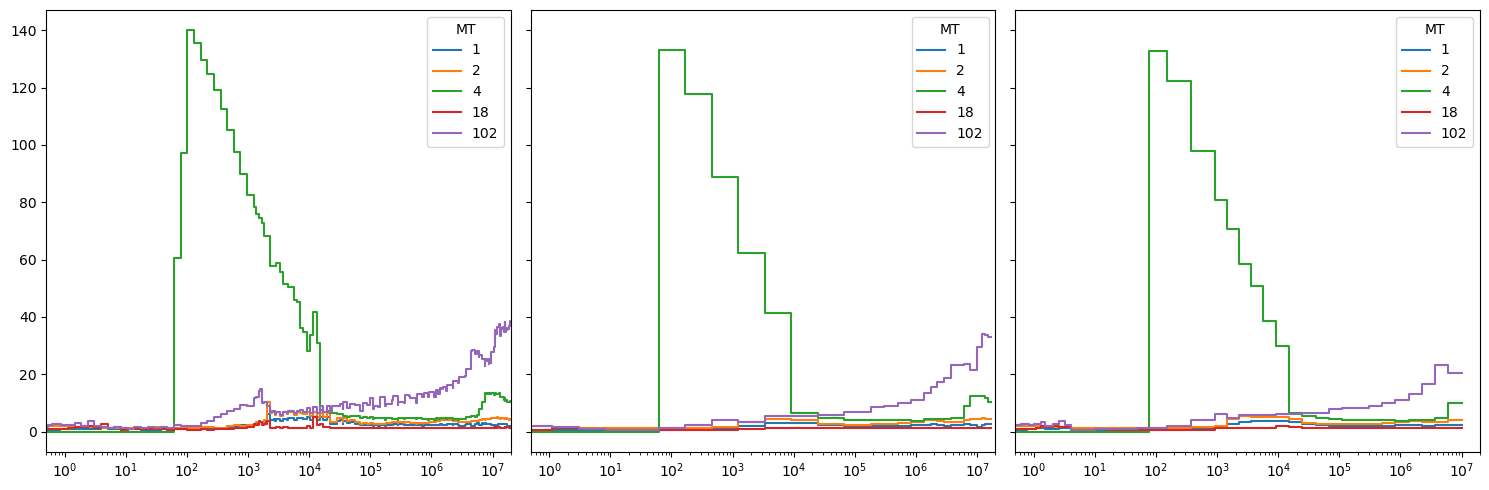

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax = axs[0]
s = covs[2].get_std().multiply(100).reset_index().pivot_table(index="E", columns="MT", values="STD")[mts]
s.index = [x.right for x in s.index]
s.plot(ax=ax, drawstyle="steps-pre", logx=True)

ax = axs[1]
s = covs[3].get_std().multiply(100).reset_index().pivot_table(index="E", columns="MT", values="STD")[mts]
s.index = [x.right for x in s.index]
s.plot(ax=ax, drawstyle="steps-pre", logx=True)

ax = axs[2]
s = covs[9].get_std().multiply(100).reset_index().pivot_table(index="E", columns="MT", values="STD")[mts]
s.index = [x.right for x in s.index]
s.plot(ax=ax, drawstyle="steps-pre", logx=True)
ax.set(xlim=(5e-1, 2e7))

fig.tight_layout()

Large uncertainty on inelastic scattering just above the threshold (where the xs is low), combined with strong positive correlation with elastic scattering.

## Eigenvalue analysis

In [8]:
keep = 20
pd.DataFrame({
    "IGN 2": sandy.CategoryCov(covs[2].data.loc[
                         idx[:, mts, :],  # Filter rows with MT in list
                         idx[:, mts, :]   # Filter columns with MT in list
                         ]).get_eig()[0].head(keep),
    "IGN 3": sandy.CategoryCov(covs[3].data.loc[
                         idx[:, mts, :],  # Filter rows with MT in list
                         idx[:, mts, :]   # Filter columns with MT in list
                         ]).get_eig()[0].head(keep),
    "IGN 9": sandy.CategoryCov(covs[9].data.loc[
                         idx[:, mts, :],  # Filter rows with MT in list
                         idx[:, mts, :]   # Filter columns with MT in list
                         ]).get_eig()[0].head(keep),
})

,IGN 2,IGN 3,IGN 9
0,2.22415e+01,4.48272e+00,6.07524e+00
1,3.24827e+00,4.14494e-01,1.51433e-01
2,1.71313e+00,1.61321e-01,1.02215e-01
3,5.89849e-01,7.02390e-02,8.74661e-02
4,5.78987e-01,4.70019e-02,-7.33621e-02
5,3.72203e-01,-3.30510e-02,5.16260e-02
6,3.31373e-01,3.67466e-02,-4.20481e-02
7,2.88805e-01,3.21582e-02,2.86757e-02
8,2.40774e-01,2.82741e-02,2.37728e-02
9,-2.09125e-01,2.32305e-02,1.98218e-02


Large negative eigenvalues.

The covariance matrix is not positive-definite (hence it is not a cvoariance matrix)!
The covariance information cannot be preserved in the sample, independently from teh samples size.

The same conclusions can be drawn from SVD, with the matrices U and V.T not being identical.

In [9]:
U, S, V = svd(sandy.CategoryCov(covs[2].data.loc[
                         idx[:, mts, :],  # Filter rows with MT in list
                         idx[:, mts, :]   # Filter columns with MT in list
                         ]).data)

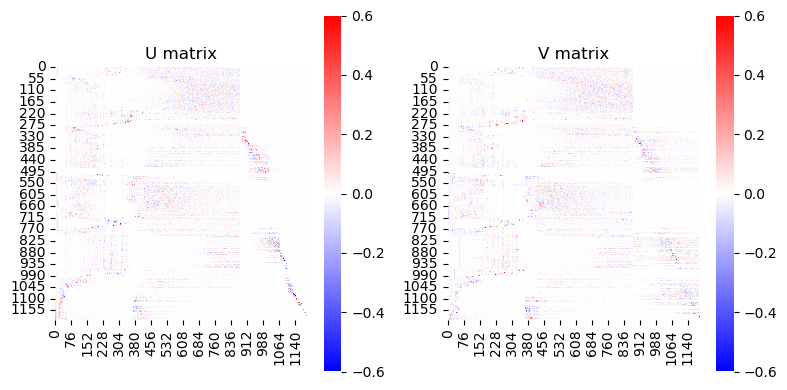

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.set_aspect("equal")
sns.heatmap(U, cmap="bwr", vmin=-0.6, vmax=0.6, ax=ax)
ax.set(title="U matrix")
ax = axs[1]
ax.set_aspect("equal")
sns.heatmap(V.T, cmap="bwr", vmin=-0.6, vmax=0.6, ax=ax)
ax.set(title="V matrix")
fig.tight_layout()